In [ ]:
pip install scikit-learn pandas matplotlib

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip --version

pip 25.1.1 from c:\project\py_project\.venv\Lib\site-packages\pip (python 3.13)

Note: you may need to restart the kernel to use updated packages.


전체 거래 수: 284807
전체 부정 거래 수: 492
DBSCAN이 탐지한 이상치 수: 50151
이상치 중 실제 부정 거래 수: 419
탐지된 부정 거래 비율: 85.16%


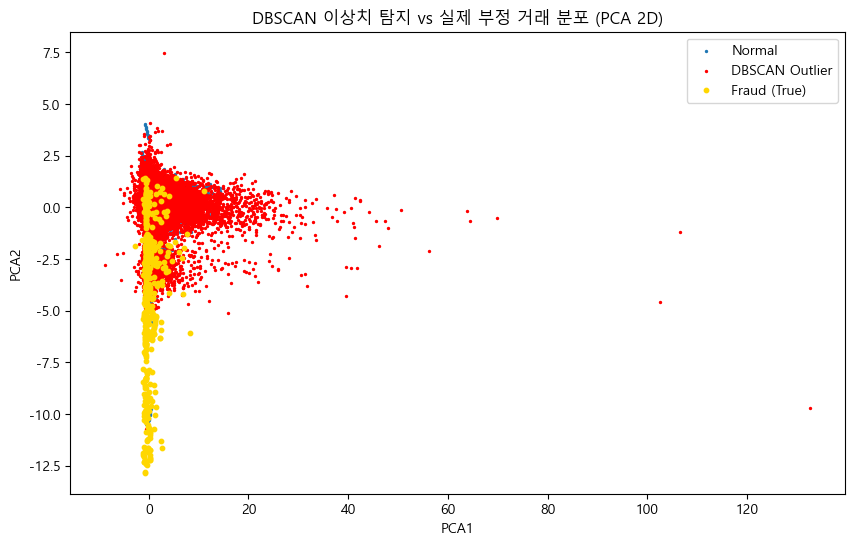

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib as mpl


df = pd.read_csv('./dataset/creditcard.csv')

# 전처리
features = df.drop(['Time', 'Class'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# eps, min_samples는 데이터 특성에 따라 조정 필요 
dbscan = DBSCAN(eps=2, min_samples=5, n_jobs=-1)    # n_jobs=-1 => 모든 CPU 코어 사용

'''
전체 거래 수: 284807
전체 부정 거래 수: 492
DBSCAN이 탐지한 이상치 수: 50151
이상치 중 실제 부정 거래 수: 419
탐지된 부정 거래 비율: 85.16%
개선을 위해 eps와 min_samples 값을 조정
- eps: 값이 크면 더 많은 포인트를 클러스터로 묶음, 작으면 더 많은 이상치로 분류됨
- min_samples: 클러스터를 형성하기 위한 최소 포인트 수, 값이 작으면 더 많은 클러스터가 생성됨

'''


dbscan_labels = dbscan.fit_predict(X_scaled)

df['dbscan_label'] = dbscan_labels

# 4. DBSCAN 결과와 실제 부정 거래 비교
# -1: 이상치(Noise), 0 이상: 정상 클러스터
outliers = df[df['dbscan_label'] == -1]
frauds = df[df['Class'] == 1]

total_outliers = len(outliers)
total_frauds = len(frauds)

detected_frauds = outliers[outliers['Class'] == 1]
detected_frauds_count = len(detected_frauds)

print(f'전체 거래 수: {len(df)}')
print(f'전체 부정 거래 수: {total_frauds}')
print(f'DBSCAN이 탐지한 이상치 수: {total_outliers}')
print(f'이상치 중 실제 부정 거래 수: {detected_frauds_count}')
print(f'탐지된 부정 거래 비율: {detected_frauds_count/total_frauds:.2%}')

# 5. 시각화 (PCA로 2차원 축소 후 시각화)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

mpl.rc('font', family='Malgun Gothic')
plt.figure(figsize=(10,6))
plt.scatter(X_pca[dbscan_labels != -1, 0], X_pca[dbscan_labels != -1, 1], s=2, label='Normal')
plt.scatter(X_pca[dbscan_labels == -1, 0], X_pca[dbscan_labels == -1, 1], s=2, color='red', label='DBSCAN Outlier')
plt.scatter(X_pca[df['Class'] == 1, 0], X_pca[df['Class'] == 1, 1], s=10, color='gold', label='Fraud (True)')
plt.legend()
plt.title('DBSCAN 이상치 탐지 vs 실제 부정 거래 분포 (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()





데이터 요약 정보:

결측치 확인:
이상치 수: 1140
정상치 수: 283667

이상치 데이터의 주요 통계:
                Time           V1           V2           V3           V4  \
count    1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
mean    88440.227193   -11.239126    -4.410636    -6.842501     3.138960   
std     48185.603476     7.728040    12.580394     6.066199     3.693340   
min       103.000000   -56.407510   -72.715728   -48.325589    -5.266509   
25%     43296.000000   -14.791087   -12.677501    -8.657540     0.081784   
50%     84674.000000    -9.386602    -2.770147    -5.368173     2.971350   
75%    133797.250000    -5.610226     5.688986    -3.168363     5.798455   
max    172786.000000     0.951025    22.057729     9.382558    16.875344   

                V5           V6           V7           V8           V9  ...  \
count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000  ...   
mean     -4.372059     1.190658    -0.792561    -2.732484     0.013139  ...   
std       8.748

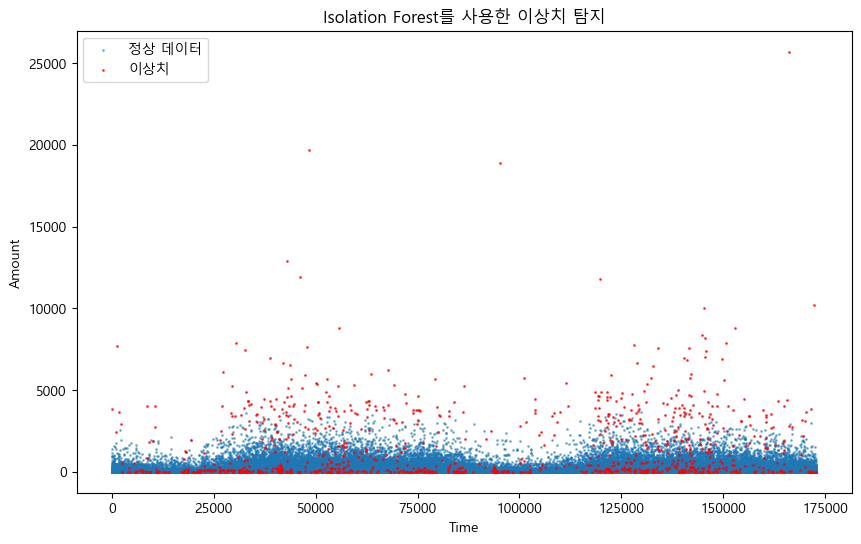

이상치 탐지가 완료되었습니다. 결과는 'outliers_detected.csv'에 저장되었습니다.


In [8]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl

data = pd.read_csv('./dataset/creditcard.csv')

# 2. 데이터 탐색
print("데이터 요약 정보:")
#print(data.info())
print("\n결측치 확인:")
#print(data.isnull().sum())

# 'Time'과 'Amount'는 전처리가 필요하므로 스케일링 전용으로 분리
features = data.drop(columns=['Class'])  # 예측 변수인 'Class'는 제외
labels = data['Class']  # 'Class'는 실제 레이블로 활용

# 'Amount'와 'Time' 컬럼은 분포가 다르기 때문에 표준화 진행
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

model = IsolationForest(n_estimators=100, contamination=0.004, random_state=42)
model.fit(features_scaled)

# 이상치 탐지 결과
# `-1`은 이상치, `1`은 정상치를 의미
predictions = model.predict(features_scaled)
data['Anomaly'] = predictions

# 이상치로 판별된 데이터를 확인
outliers = data[data['Anomaly'] == -1]
normal = data[data['Anomaly'] == 1]
print(f"이상치 수: {len(outliers)}")
print(f"정상치 수: {len(normal)}")

# 이상치 범주 출력
print("\n이상치 데이터의 주요 통계:")
print(outliers.describe())

print("\nClass와 Anomaly의 관계 분석:")
comparison = data.groupby(['Class', 'Anomaly']).size().unstack(fill_value=0)
print(comparison)

mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
# Amount와 Time을 기준으로 이상치와 정상치를 시각화
plt.figure(figsize=(10, 6))
plt.scatter(normal['Time'], normal['Amount'], label='정상 데이터', s=1, alpha=0.5)
plt.scatter(outliers['Time'], outliers['Amount'], label='이상치', color='red', s=1,  alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Isolation Forest를 사용한 이상치 탐지')
plt.legend()
plt.show()

# 이상치 탐지 결과를 CSV 파일로 저장
outliers.to_csv('outliers_detected.csv', index=False)

print("이상치 탐지가 완료되었습니다. 결과는 'outliers_detected.csv'에 저장되었습니다.")

# 분류 report 출력
#from sklearn.metrics import classification_report
#print(classification_report(data['Class'], data['Anomaly'], zero_division=0))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

d:\project\python_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


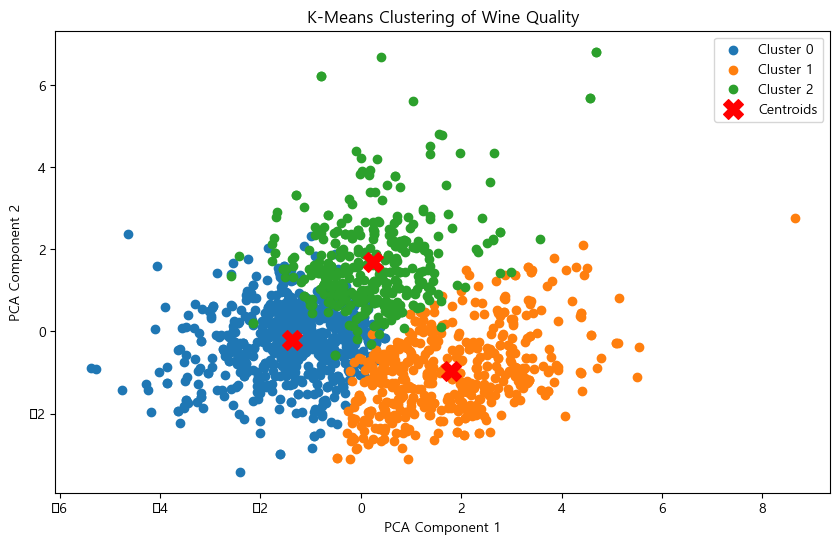


클러스터별 기초 통계:
  Cluster   quality                      alcohol                       \
               mean       std min max       mean       std  min   max   
0       0  5.552632  0.802648   3   8  10.494044  1.088952  9.0  14.0   
1       1  5.960159  0.846742   3   8  10.724037  1.083720  8.4  14.9   
2       2  5.362667  0.595611   4   8   9.883156  0.754609  8.5  12.9   

  volatile acidity                        
              mean       std   min   max  
0         0.609342  0.171471  0.16  1.58  
1         0.405080  0.126141  0.12  0.89  
2         0.535173  0.160909  0.18  1.24  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('winequality-red.csv')
print(data.head())

features = data.drop(columns=['quality'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

cluster_means = data.groupby('Cluster').mean()
print("클러스터별 평균값:")
print(cluster_means)

cluster_quality = data.groupby('Cluster')['quality'].mean()
print("클러스터별 품질 점수 평균:")
print(cluster_quality)

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))
for cluster in range(3):
    cluster_data = pca_features[data['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

centroids = kmeans.cluster_centers_
pca_centroids = pca.transform(centroids)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title('K-Means Clustering of Wine Quality')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# 각 클러스터별 기초 통계 비교
cluster_stats = data.groupby('Cluster').agg({
    'quality': ['mean', 'std', 'min', 'max'],
    'alcohol': ['mean', 'std', 'min', 'max'],
    'volatile acidity': ['mean', 'std', 'min', 'max']
}).reset_index()    
print("\n클러스터별 기초 통계:")
print(cluster_stats)

'''

'''
